# Website Traffic Analysis

The goal of this project is to understand this traffic better, in particular the volume and distribution of events, and to develop ideas how to increase the links' clickrates. With that in mind, please analyze the data using the Python libraries Pandas and SciPy where indicated, providing answers to the presented questions:

    1. How many total pageview events did the links in the provided dataset receive in the full period, how many per day?
    2. What about the other recorded events?
    3. Which countries did the pageviews come from?
    4. What was the overall click rate (clicks/pageviews)?
    5. How does the clickrate distribute across different links?
    6. Is there any correlation between clicks and previews on a link? Is it significant? How large is the effect? Make sure to at least test for potential linear as well as categorical relationships between both variables.
    

Data Description
The data set provided (traffic.csv) contains web traffic data ("events") from a few different pages ("links") over a period of 7 days including various categorical dimensions about the geographic origin of that traffic as well as a page's content: https://isrc.ifpi.org/en/

In [124]:
# Import libraries
import pandas as pd
import numpy as np
import re
import glob
import os.path
import calendar
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.cluster import DBSCAN
from kmodes.kmodes import KModes
from sklearn.preprocessing import MinMaxScaler
from pandas.api.types import is_numeric_dtype
from pandas_profiling import ProfileReport
import dtale
from scipy import stats
import sweetviz as sv
pd.set_option('display.max_rows', 99999)
pd.set_option('display.max_columns', 99999)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.act_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')

In [73]:
# Read data
df_ = pd.read_csv(r"C:\Users\krish\Desktop\StrataScratch\Data Projects\Website Traffic Analysis - Linkfire\datasets\traffic.csv")

### Data Understanding


In [74]:
df = df_.copy()

In [75]:
df.shape

(226278, 9)

In [76]:
df.head(2)

,event,date,country,city,artist,album,track,isrc,linkid
0,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8
1,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8


In [77]:
# drop duplicates as we can see the first two observations
df.drop_duplicates(inplace=True)

In [78]:
df.shape

(122567, 9)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122567 entries, 0 to 226274
Data columns (total 9 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   event    122567 non-null  object
 1   date     122567 non-null  object
 2   country  122562 non-null  object
 3   city     122562 non-null  object
 4   artist   122539 non-null  object
 5   album    122563 non-null  object
 6   track    122563 non-null  object
 7   isrc     116261 non-null  object
 8   linkid   122567 non-null  object
dtypes: object(9)
memory usage: 9.4+ MB


In [43]:
# Missing data
def missing_data(data):
    missing = data.isna().sum()
    percent_missing = (data.isna().sum()/data.isna().count()*100)   
    total_count = data.count()
    temp = pd.concat([total_count,missing, percent_missing], axis=1, keys=['Total','Missing', 'Missing(%)'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    temp['Types'] = types
    temp.sort_values('Missing(%)',ascending=False ,inplace=True)
    temp.reset_index(inplace=True)
    temp.rename(columns={'index':'column_name'}, inplace=True)
    
    return(temp)

In [44]:
missing_data(df)

,column_name,Total,Missing,Missing(%),Types
0,isrc,116261,6306,5.144941,object
1,artist,122539,28,0.022845,object
2,country,122562,5,0.004079,object
3,city,122562,5,0.004079,object
4,album,122563,4,0.003264,object
5,track,122563,4,0.003264,object
6,event,122567,0,0.000000,object
7,date,122567,0,0.000000,object
8,linkid,122567,0,0.000000,object


In [45]:
# nunique
def nunique(df):
    df1 = pd.DataFrame(df.count()).reset_index().rename({'index':'Variable Name',0:'Count'},axis=1)
    df2 = pd.DataFrame(df.nunique()).reset_index().rename({'index':'Variable Name',0:'Unique Count'},axis=1)
    return(pd.merge(df1,df2,on='Variable Name'))

In [46]:
nunique(df)

,Variable Name,Count,Unique Count
0,event,122567,3
1,date,122567,7
2,country,122562,211
3,city,122562,11993
4,artist,122539,2419
5,album,122563,3254
6,track,122563,3562
7,isrc,116261,709
8,linkid,122567,3839


In [47]:
# check for variance
def var(df):
    return(pd.DataFrame(np.var(df,axis=0)).reset_index().rename({'index':'Variable Name',0:'Variance'},axis=1).round(3))

In [48]:
var(df)

,Variable Name,Variance


There are no variance because all variables are categorical

In [49]:
# description of data
def describe(df):
    return(df.describe(include='all',percentiles=[.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99]).round(2).T.reset_index().rename({'index':'Variable Name'},axis=1))

In [50]:
describe(df)

,Variable Name,count,unique,top,freq
0,event,122567,3,pageview,73360
1,date,122567,7,2021-08-19,21156
2,country,122562,211,United States,28664
3,city,122562,11993,Unknown,8797
4,artist,122539,2419,Tesher,8288
5,album,122563,3254,Jalebi Baby,8288
6,track,122563,3562,Jalebi Baby,8288
7,isrc,116261,709,QZNWQ2070741,8288
8,linkid,122567,3839,2d896d31-97b6-4869-967b-1c5fb9cd4bb8,8288


In [51]:
# value counts
def valcount(df):
    df1=pd.DataFrame(df.apply(lambda x:x.astype(str).value_counts()[:6]).T.stack()).reset_index().rename({'level_0':'Variable Name','level_1':'Value',0:'Value Counts'},axis=1)
    df2=pd.DataFrame(df.apply(lambda x:x.astype(str).value_counts()[:6]).mul(100).round(2).T.stack()).reset_index().rename({'level_0':'Variable Name','level_1':'Value',0:'Value Counts'},axis=1)
    return(pd.merge(df1,df2,on=['Variable Name','Value']))

In [52]:
valcount(df)

,Variable Name,Value,Value Counts_x,Value Counts_y
0,event,click,32499.0,3249900.0
1,event,pageview,73360.0,7336000.0
2,event,preview,16708.0,1670800.0
3,date,2021-08-19,21156.0,2115600.0
4,date,2021-08-20,18536.0,1853600.0
5,date,2021-08-21,16701.0,1670100.0
6,date,2021-08-22,16927.0,1692700.0
7,date,2021-08-23,16415.0,1641500.0
8,date,2021-08-25,16541.0,1654100.0
9,country,France,10565.0,1056500.0


In [53]:
# Univeriate - Numerical

def UnivNum(df):
    if df.select_dtypes(include='number').shape[1] <= 10:
        df.select_dtypes(include='number').hist(figsize=(10,5),bins=30,edgecolor='black',grid=False,color='royalblue')
        plt.show();
    else:
        df.select_dtypes(include='number').hist(figsize=(35,20),bins=30,edgecolor='black',grid=False,color='royalblue')
        plt.show();

In [54]:
# Univeriate - Categorical

def UnivCat(df):
    name=[x for x in globals() if globals()[x] is df][0]
    print(name)
    print('\n')
    df=df.select_dtypes(include='object')
    for col in df.columns:
        print(col)
        df[col].value_counts(dropna=False)[:15].plot(kind='bar',figsize=(10,5))
        plt.xticks(rotation=45)
        plt.show();

df


event


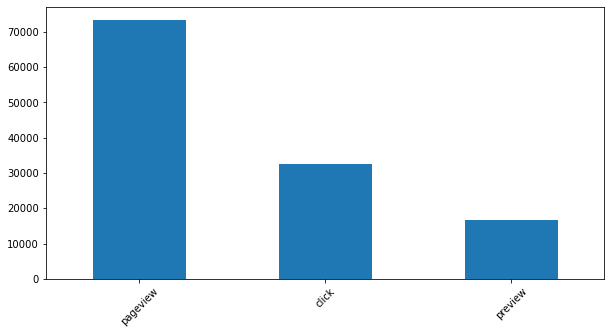

date


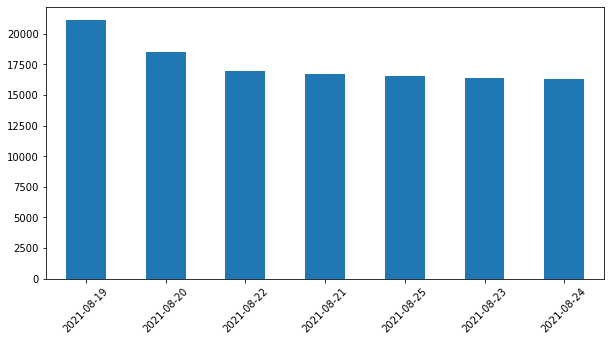

country


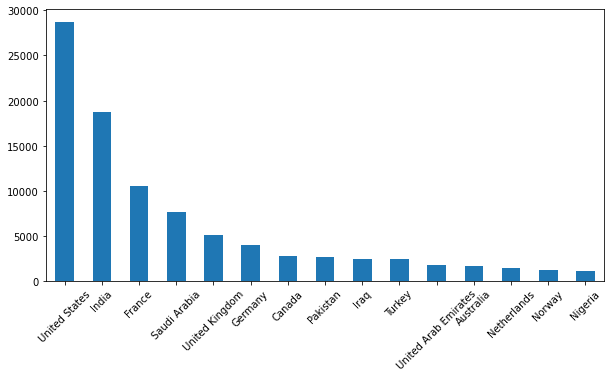

city


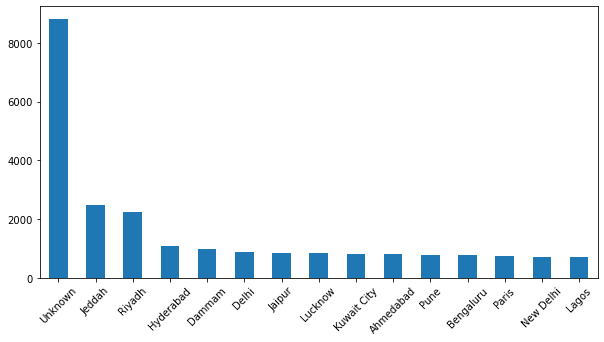

artist


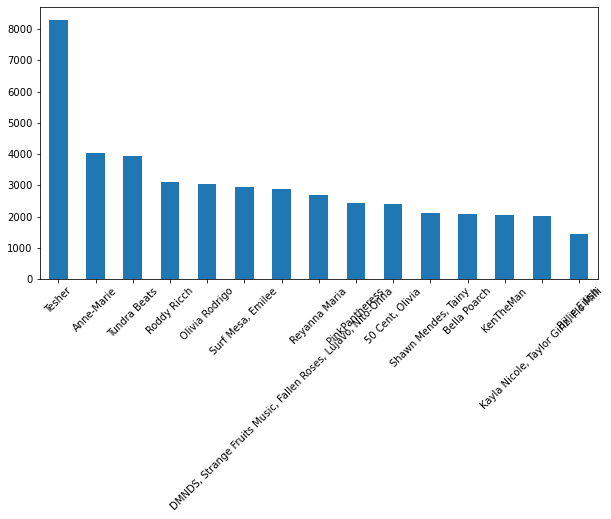

album


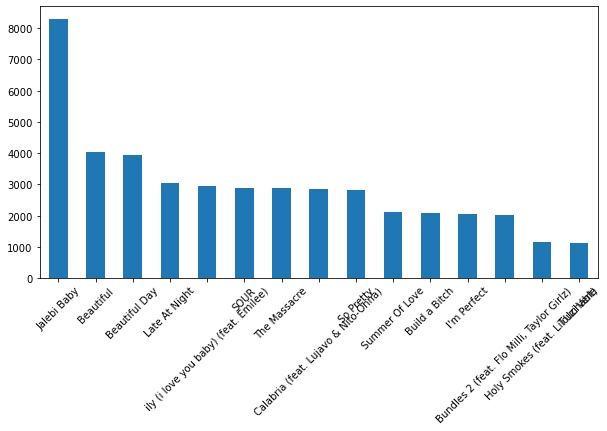

track


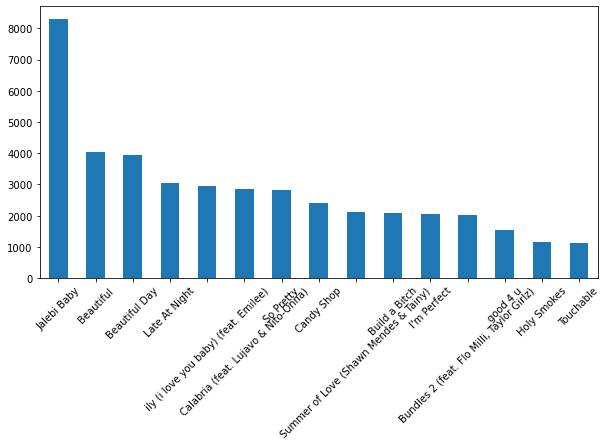

isrc


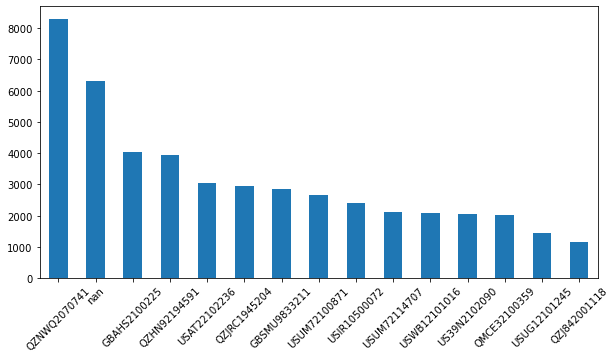

linkid


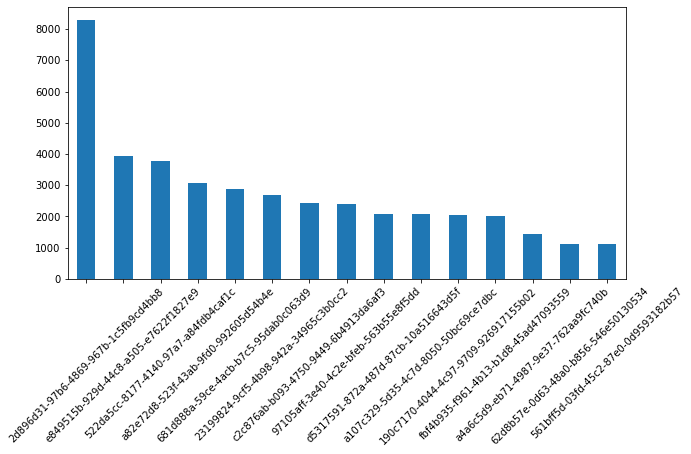

In [55]:
UnivCat(df)

The above graphs gives us a better understanding about the data on variable level.

### Assignment

###### Question 1

How many total pageview events did the links in the provided dataset receive in the full period, how many per day?

In [56]:
df_pageview = df[df.event=='pageview']
df_pageview.shape

(73360, 9)

In [57]:
df_pageview.groupby(['date'])['event'].count()

date
2021-08-19    13006
2021-08-20    11088
2021-08-21     9939
2021-08-22     9982
2021-08-23     9722
2021-08-24     9705
2021-08-25     9918
Name: event, dtype: int64

###### Question 2

What about the other recorded events?

In [59]:
df_otherevents = df[~(df.event=='pageview')]
df_otherevents.shape

(49207, 9)

In [66]:
print("Event-Click:\n",df_otherevents[df_otherevents.event=='click'].groupby(['date'])['event'].count())
print("\nEvent-Preview:\n",df_otherevents[df_otherevents.event=='preview'].groupby(['date'])['event'].count())

Event-Click:
 date
2021-08-19    5860
2021-08-20    4999
2021-08-21    4279
2021-08-22    4421
2021-08-23    4314
2021-08-24    4231
2021-08-25    4395
Name: event, dtype: int64

Event-Preview:
 date
2021-08-19    2290
2021-08-20    2449
2021-08-21    2483
2021-08-22    2524
2021-08-23    2379
2021-08-24    2355
2021-08-25    2228
Name: event, dtype: int64


###### Question 3

Which countries did the pageviews come from?

In [97]:
df_pageview.country.unique()

array(['Saudi Arabia', 'United States', 'Ireland', 'United Kingdom',
       'France', 'Guatemala', 'Jordan', 'Kuwait', 'Pakistan', 'Italy',
       'Germany', 'Iraq', 'Peru', 'India', 'Nicaragua', 'Rwanda',
       'Tanzania', 'United Arab Emirates', 'Norway', 'Oman', 'Bahamas',
       'Algeria', 'Czechia', 'Mexico', 'Jamaica', 'Netherlands',
       'Colombia', 'Morocco', 'Australia', 'Myanmar', 'Uzbekistan',
       'Austria', 'Latvia', 'Turkey', 'Mauritania', 'Sri Lanka',
       'Bosnia and Herzegovina', 'Estonia', 'Nigeria', 'Bulgaria',
       'Greece', 'El Salvador', 'Philippines', 'Denmark', 'Serbia',
       'Canada', 'Spain', 'Libya', 'Palestine', 'Chad', 'Ecuador', 'Mali',
       'Romania', 'Switzerland', 'Portugal', 'Slovenia', 'Iceland',
       'Sweden', 'Bahrain', 'Egypt', 'Lithuania', 'Liberia', 'Israel',
       'Ukraine', 'Puerto Rico', 'South Africa', 'Ghana', 'Kenya',
       'Armenia', 'Nepal', 'Barbados', 'Azerbaijan', 'Qatar', 'Uganda',
       'Poland', 'Brazil', 'Guyana',

###### Question 4

What was the overall click rate (clicks/pageviews)?

The click rate is the number of clicks that a page has received (event = 'click') divided by the number of times it has been shown (event = 'pageview'). It is a commonly used metric that measures the success of an advertising campaign.

I use the dataset with duplicates since the question is for overall clicks and one user could be have multiple page visit to one website and multiple clicks to the website in the same day. Since we do not have timestamp, it becomes difficult to drop duplicates.

In [98]:
Click_Rate = pd.DataFrame({'Click':df_[df_.event=='click'].groupby(['linkid'])['event'].count(),'Pageview':df_[df_.event=='pageview'].groupby(['linkid'])['event'].count(),'Click Rate':df_[df_.event=='click'].groupby(['linkid'])['event'].count()/df_[df_.event=='pageview'].groupby(['linkid'])['event'].count()}).dropna().reset_index()
Click_Rate.head()

,linkid,Click,Pageview,Click Rate
0,00126b32-0c35-507b-981c-02c80d2aa8e7,2.0,2.0,1.000000
1,004b9724-abca-5481-b6e9-6148a7ca00a5,1.0,1.0,1.000000
2,0063a982-41cd-5629-96d0-e1c4dd72ea11,2.0,3.0,0.666667
3,006af6a0-1f0d-4b0c-93bf-756af9071c06,8.0,36.0,0.222222
4,00759b81-3f04-4a61-b934-f8fb3185f4a0,3.0,4.0,0.750000


###### Question 5

How does the clickrate distribute across different links?

In [105]:
describe(Click_Rate)

,Variable Name,count,unique,top,freq,mean,std,min,1%,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
0,linkid,2253,2253,00126b32-0c35-507b-981c-02c80d2aa8e7,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Click,2253.0,NaN,NaN,NaN,24.74,232.01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,21.8,389.88,9692.0
2,Pageview,2253.0,NaN,NaN,NaN,62.15,607.89,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,7.0,57.0,915.4,25175.0
3,Click Rate,2253.0,NaN,NaN,NaN,0.81,1.96,0.09,0.17,0.33,0.44,0.5,0.61,1.0,1.0,1.0,1.0,1.0,2.0,92.3


<AxesSubplot:ylabel='Density'>

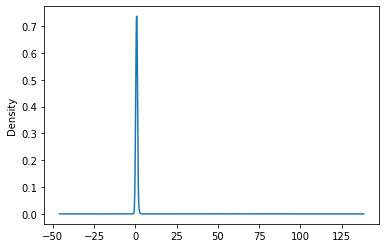

In [100]:
Click_Rate['Click Rate'].plot(kind='kde')

###### Question 6

Is there any correlation between clicks and previews on a link? Is it significant? How large is the effect? Make sure to at least test for potential linear as well as categorical relationships between both variables.

In [107]:
df.head()

,event,date,country,city,artist,album,track,isrc,linkid
0,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8
2,click,2021-08-21,India,Ludhiana,Reyanna Maria,So Pretty,So Pretty,USUM72100871,23199824-9cf5-4b98-942a-34965c3b0cc2
3,click,2021-08-21,France,Unknown,"Simone & Simaria, Sebastian Yatra",No Llores Más,No Llores Más,BRUM72003904,35573248-4e49-47c7-af80-08a960fa74cd
4,click,2021-08-21,Maldives,Malé,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8
5,click,2021-08-21,United States,Los Angeles,KenTheMan,I'm Perfect,I'm Perfect,US39N2102090,190c7170-4044-4c97-9709-926917155b02


In [108]:
df_click_preview = df[df.event.isin(['click','preview'])]
df_click_preview.shape

(49207, 9)

In [109]:
describe(df_click_preview)

,Variable Name,count,unique,top,freq
0,event,49207,2,click,32499
1,date,49207,7,2021-08-19,8150
2,country,49205,206,United States,10533
3,city,49205,8137,Unknown,3749
4,artist,49198,1549,Tesher,3712
5,album,49206,2003,Jalebi Baby,3712
6,track,49206,2155,Jalebi Baby,3712
7,isrc,47246,628,QZNWQ2070741,3712
8,linkid,49207,2286,2d896d31-97b6-4869-967b-1c5fb9cd4bb8,3712


In [115]:
df_click_preview = pd.DataFrame({'Click':df[df.event=='click'].groupby(['linkid'])['event'].count(),'Preview':df[df.event=='preview'].groupby(['linkid'])['event'].count()}).dropna().reset_index()
df_click_preview_final = pd.merge(left=df, right=df_click_preview, how="left", on="linkid")

In [116]:
df_click_preview_final.dropna(subset=["Click", "Preview"], inplace=True)

In [117]:
df_click_preview_final.shape

(112097, 11)

In [122]:
# correlation - numerical variables
df_click_preview_final.corr()

,Click,Preview
Click,1.000000,0.983473
Preview,0.983473,1.000000


In [125]:
stats.pearsonr(x=df_click_preview_final["Click"], y=df_click_preview_final["Preview"])

(0.9834733364086174, 0.0)

High positive correlation between the number of clicks and previews (clicks wont happen without previews and vice-versa)

In [130]:
# correlation - categorical variables
cat_cols = ["country", "city", "artist", "album", "track"]
df[cat_cols].apply(lambda x: pd.factorize(x)[0]).corr()

,country,city,artist,album,track
country,1.000000,0.112272,-0.043252,-0.045882,-0.046744
city,0.112272,1.000000,0.007946,0.019207,0.021798
artist,-0.043252,0.007946,1.000000,0.894180,0.867132
album,-0.045882,0.019207,0.894180,1.000000,0.960619
track,-0.046744,0.021798,0.867132,0.960619,1.000000


High positive correlation between album, artist, and track and almost no correlation between other variables. Makes sense since each track belongs to an album which is performed by an artist.